# LSTM Long Short Term Memory

The Long Short-Term Memory recurrent neural network has the promise of learning long sequences of observations.<br>
In this tutorial, we will discover how to develop an LSTM forecast model for a one-step univariate time series forecasting problem.

<ul>
    <li>How to develop a baseline of performance for a forecast problem.</li>
    <li>How to design a robust test harness for one-step time series forecasting.</li>
    <li>How to prepare data, develop, and evaluate an LSTM recurrent neural network for time series forecasting</li>
</ul>

In [1]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense


In [2]:
heartrate_df = pd.read_csv ('.\Data\HEARTRATE_AUTO_1658994387948.csv', sep=',', header=0)

In [3]:
heartrate_df['date'] = pd.to_datetime(heartrate_df['date'],infer_datetime_format=True) #convert from string to datetime
heartrate_df['time'] = pd.to_datetime(heartrate_df['time'], format='%H:%M').dt.strftime("%H:%M")

heartrate_df['date'] = pd.to_datetime(heartrate_df['date'].astype(str)+' '+heartrate_df['time'].astype(str), format='%Y-%m-%d %H:%M')
heartrate_df['date'] = heartrate_df['date'].dt.strftime('%Y-%m-%d %H:%M')
heartrate_df = heartrate_df.drop(columns=['time'])

# generating the indexed dataset
indexed_dataset = heartrate_df.set_index(['date'])

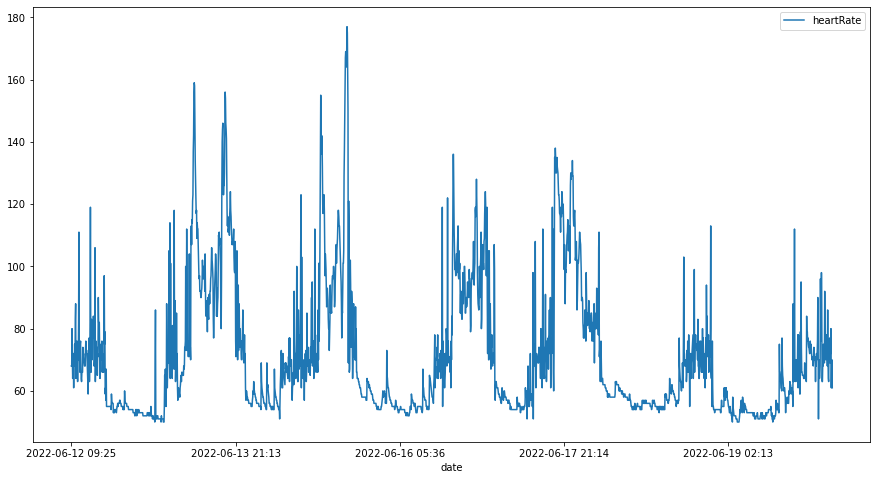

In [4]:
indexed_dataset.plot(figsize=(15,8))
plt.show()

In [20]:
all_values = indexed_dataset.values.ravel()
# prepare training dataset
train_size = len(heartrate_df) -331
train, test = indexed_dataset[0:train_size].values.ravel().tolist(), indexed_dataset[train_size:].values.ravel().tolist()
history = [x for x in train]
predictions = list()

In [21]:
all_values

array([68, 68, 80, ..., 70, 70, 61], dtype=int64)

RMSE: 6.956


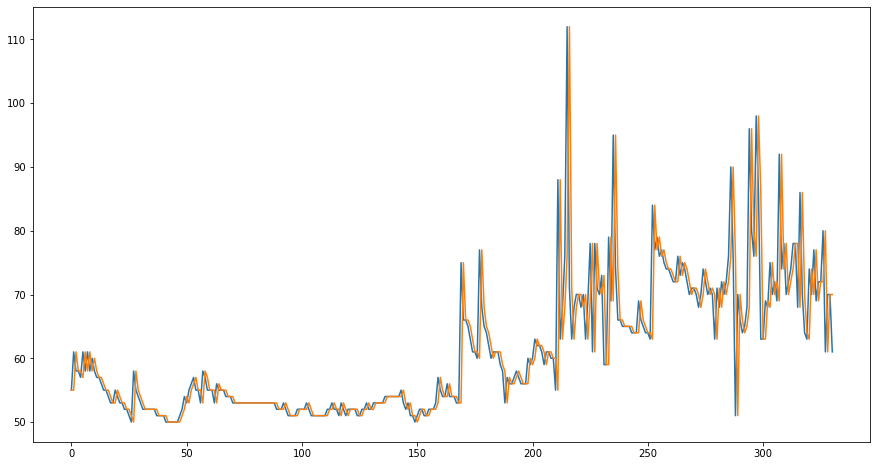

In [77]:
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize = (15,8)) # declaire environment to draw
plt.plot(test)
plt.plot(predictions)
plt.show()

Now that we have a baseline of performance on the dataset, we can get started developing an LSTM model for the data.

# LSTM Data Preparation


Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

<ol>
    <li>Transform the time series into a supervised learning problem</li>
    <li>Transform the time series data so that it is stationary.</li>
    <li>Transform the observations to have a specific scale.</li>
</ol>

## Transform Time Series to Supervised Learning


The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero sales on this dataset has not been observed.

The code below defines a helper function to do this called timeseries_to_supervised(). It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.

In [17]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 

In [79]:
# transform to supervised learning
X = indexed_dataset.values
supervised = timeseries_to_supervised(X, 1)
supervised

,0,0
0,0.0,68
1,68.0,68
2,68.0,80
3,80.0,70
4,70.0,64
...,...,...
2312,72.0,80
2313,80.0,61
2314,61.0,70
2315,70.0,70


## Transform Time Series to Stationary


Non stationarity means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value

<u>(IN THE HEART RATE EXAMPLE PROBABLY THERE IS NO THIS PROBLEM)</u>

In [11]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [12]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [13]:
# transform to be stationary
differenced = difference(all_values, 1)
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(all_values, differenced[i], len(all_values)-i)
    inverted.append(value)
inverted = pd.Series(inverted)


## Transform Time Series to Scale


Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

In [83]:
# transform scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(all_values)
scaled_X = scaler.transform(all_values)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())

0   -0.716535
1   -0.716535
2   -0.527559
3   -0.685039
4   -0.779528
dtype: float64


In [84]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

0    68.0
1    68.0
2    80.0
3    70.0
4    64.0
dtype: float64


Running the example first prints the first 5 rows of the loaded data, then the first 5 rows of the scaled data, then the first 5 rows with the scale transform inverted, matching the original data.

# LSTM

## LSTM Model Development


The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).<br>
A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

<ul>
    <li>Samples: These are independent observations from the domain, typically rows of data.</li>
    <li>Time steps: These are separate time steps of a given variable for a given observation.</li>
    <li>Features: These are separate measures observed at the time of observation.</li>
</ul>
We have some flexibility in how the heartrate dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format, for example:



In [85]:
#X, y = train[:, 0:-1], train[:, -1]
#X = X.reshape(X.shape[0], 1, X.shape[1])

The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.

The batch size is often much smaller than the total number of samples. It, along with the number of epochs, defines how quickly the network learns the data (how often the weights are updated).

The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.

The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer via the “batch_input_shape” argument.

In [86]:
#layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)

The network requires a single neuron in the output layer with a linear activation to predict the number of shampoo sales at the next time step.

Once the network is specified, it must be compiled into an efficient symbolic representation using a backend mathematical library, such as TensorFlow or Theano.

In compiling the network, we must specify a loss function and optimization algorithm. We will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, and the efficient ADAM optimization algorithm.

Using the Sequential Keras API to define the network, the below snippet creates and compiles the network

In [87]:
#model = Sequential()
#model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

Once compiled, it can be fit to the training data. Because the network is stateful, we must control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs.

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting “shuffle” to “False“.

Also by default, the network reports a lot of debug information about the learning progress and skill of the model at the end of each epoch. We can disable this by setting the “verbose” argument to the level of “0“.

We can then reset the internal state at the end of the training epoch, ready for the next training iteration.

Below is a loop that manually fits the network to the training data.

In [88]:
#for i in range(nb_epoch):
    #model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #model.reset_states()

Putting this all together, we can define a function called fit_lstm() that trains and returns an LSTM model. As arguments, it takes the training dataset in a supervised learning format, a batch size, a number of epochs, and a number of neurons.

In [10]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(neurons))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

The batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets.

The predict() function on the model is also constrained by the batch size; there it must be set to 1 because we are interested in making one-step forecasts on the test data.

We will not tune the network parameters in this tutorial; instead we will use the following configuration, found with a little trial and error:
<ul>
    <li>Batch Size: 1 </li>
    <li>Epochs: 3000</li>
    <li>Neurons: 4</li>
</ul>

As an extension to this tutorial, you might like to explore different model parameters and see if you can improve performance.<br>
<b>Update</b>: Consider trying 1500 epochs and 1 neuron, the performance may be better!


## LSTM Forecast

Once the LSTM model is fit to the training data, it can be used to make forecasts.

Again, we have some flexibility. We can decide to fit the model once on all of the training data, then predict each new time step one at a time from the test data (we’ll call this the fixed approach), or we can re-fit the model or update the model each time step of the test data as new observations from the test data are made available (we’ll call this the dynamic approach).

In this tutorial, we will go with the fixed approach for its simplicity, although, we would expect the dynamic approach to result in better model skill.

To make a forecast, we can call the predict() function on the model. This requires a 3D NumPy array input as an argument. In this case, it will be an array of one value, the observation at the previous time step.

The predict() function returns an array of predictions, one for each input row provided. Because we are providing a single input, the output will be a 2D NumPy array with one value.

We can capture this behavior in a function named forecast() listed below. Given a fit model, a batch-size used when fitting the model (e.g. 1), and a row from the test data, the function will separate out the input data from the test row, reshape it, and return the prediction as a single floating point value.

In [90]:
def forecast(model, batch_size, row):
    X = row[0:-1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

During training, the internal state is reset after each epoch. While forecasting, we will not want to reset the internal state between forecasts. In fact, we would like the model to build up state as we forecast each time step in the test dataset.

This raises the question as to what would be a good initial state for the network prior to forecasting the test dataset.

In this tutorial, we will seed the state by making a prediction on all samples in the training dataset. In theory, the internal state should be set up ready to forecast the next time step.

We now have all of the pieces to fit an LSTM Network model for the Shampoo Sales dataset and evaluate its performance.

In the next section, we will put all of these pieces together.

# Complete LSTM Example

This will involve drawing together all of the elements from the prior sections. There are a lot of them, so let’s review:

1.Load the dataset from CSV file.<br>
2.Transform the dataset to make it suitable for the LSTM model, including:<br>
 2a.Transforming the data to a supervised learning problem.<br>
 2b.Transforming the data to be stationary.<br>
 2c.Transforming the data so that it has the scale -1 to 1.<br>
3.Fitting a stateful LSTM network model to the training data.<br>
4.Evaluating the static LSTM model on the test data.<br>
5.Report the performance of the forecasts.<br><br>
Some things to note about the example:

<ul>
<li>The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.</li>
<li>The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.</li>
<li>The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.</li>
<li>Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.</li>
</ul>
The complete example is listed below.

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


In [14]:
# PHASE 1
# load dataset
# Yet done in var: all_values


In [15]:
train = np.array(train).reshape(-1, 1)
test = np.array(test).reshape(-1, 1)

In [33]:
# PHASE 2b
# transform data to be stationary
diff_values = difference(all_values, 1)

# PHASE 2a
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets: Done yet
train, test = supervised_values[0:-331], supervised_values[-331:]

# PHASE 2c
scaler, train_scaled, test_scaled = scale(train, test)

In [37]:
# PHASE 3
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1) #try next with 1500 epoch and 1 neuron

In [38]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[0.09460017],
       [0.18216026],
       [0.16062605],
       ...,
       [0.22538733],
       [0.22524288],
       [0.22518271]], dtype=float32)

In [39]:
# PHASE 4
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(all_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = all_values[len(train) + i ]
    print('Measure=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))



Measure=1, Predicted=55.472928, Expected=55.000000
Measure=2, Predicted=55.472183, Expected=55.000000
Measure=3, Predicted=60.105238, Expected=61.000000
Measure=4, Predicted=58.742264, Expected=58.000000
Measure=5, Predicted=58.487340, Expected=58.000000
Measure=6, Predicted=57.689418, Expected=57.000000
Measure=7, Predicted=60.636425, Expected=61.000000
Measure=8, Predicted=58.897756, Expected=58.000000
Measure=9, Predicted=60.887589, Expected=61.000000
Measure=10, Predicted=58.966751, Expected=58.000000
Measure=11, Predicted=60.139436, Expected=60.000000
Measure=12, Predicted=58.826745, Expected=58.000000
Measure=13, Predicted=57.768760, Expected=57.000000
Measure=14, Predicted=57.559325, Expected=57.000000
Measure=15, Predicted=56.723337, Expected=56.000000
Measure=16, Predicted=55.758468, Expected=55.000000
Measure=17, Predicted=55.556471, Expected=55.000000
Measure=18, Predicted=54.722170, Expected=54.000000
Measure=19, Predicted=53.757974, Expected=53.000000
Measure=20, Predicted

Measure=159, Predicted=52.451911, Expected=52.000000
Measure=160, Predicted=53.245078, Expected=53.000000
Measure=161, Predicted=56.517018, Expected=57.000000
Measure=162, Predicted=55.637914, Expected=55.000000
Measure=163, Predicted=54.691644, Expected=54.000000
Measure=164, Predicted=54.526181, Expected=54.000000
Measure=165, Predicted=56.054196, Expected=56.000000
Measure=166, Predicted=54.794732, Expected=54.000000
Measure=167, Predicted=54.539736, Expected=54.000000
Measure=168, Predicted=54.497775, Expected=54.000000
Measure=169, Predicted=53.698418, Expected=53.000000
Measure=170, Predicted=53.532201, Expected=53.000000
Measure=171, Predicted=67.528676, Expected=75.000000
Measure=172, Predicted=65.907117, Expected=66.000000
Measure=173, Predicted=65.994405, Expected=66.000000
Measure=174, Predicted=65.475300, Expected=65.000000
Measure=175, Predicted=63.865430, Expected=63.000000
Measure=176, Predicted=61.994069, Expected=61.000000
Measure=177, Predicted=61.618818, Expected=61.

Measure=320, Predicted=65.993762, Expected=64.000000
Measure=321, Predicted=64.089699, Expected=63.000000
Measure=322, Predicted=72.013916, Expected=74.000000
Measure=323, Predicted=70.652980, Expected=70.000000
Measure=324, Predicted=75.809990, Expected=77.000000
Measure=325, Predicted=70.686178, Expected=69.000000
Measure=326, Predicted=72.044964, Expected=72.000000
Measure=327, Predicted=72.384797, Expected=72.000000
Measure=328, Predicted=78.567777, Expected=80.000000
Measure=329, Predicted=64.882820, Expected=61.000000
Measure=330, Predicted=69.148433, Expected=70.000000
Measure=331, Predicted=70.192397, Expected=70.000000


Test RMSE: 5.966


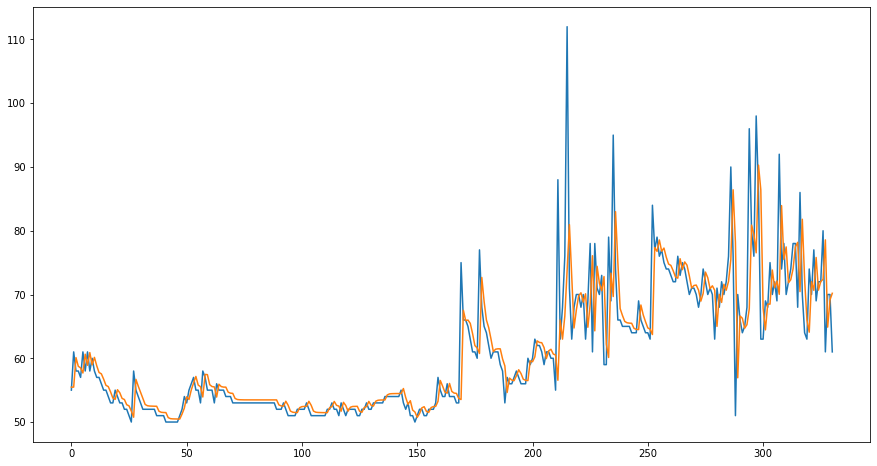

In [40]:
# PHASE 5
# report performance

rmse = sqrt(mean_squared_error(all_values[-len(test):], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(15,8))
plt.plot(all_values[-len(test):])
plt.plot(predictions)
plt.show()